## Import 

In [1]:
import warnings
warnings.filterwarnings(action = 'ignore')

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [2]:
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
import prepare_sub_image as ps
import cv2
import numpy as np
from skimage import measure
import PIL.Image as pilimg
import matplotlib.pyplot as plt
import math
from scipy import io
from collections import defaultdict

## Metrics 

In [3]:
def ssim(target, ref):
    target_data = np.array(target)
    ref_data = np.array(ref)
    
    (score, diff) = measure.compare_ssim(target_data, ref_data, full = True, multichannel=True)
    
    return score

def psnr(target, ref):
    
    target_data = np.array(target, dtype = float)
    ref_data = np.array(ref, dtype = float)
    
    diff = ref_data - target_data
    diff = diff.flatten('C')
    
    rmse = math.sqrt(np.mean(diff**2))
    
    return 20 * math.log10(255/rmse)

## Model 

In [4]:
rgb_mean = np.array([0.4488, 0.4371, 0.4040])


def res_block(x, filters, i):
    
    input_img = x
    
    x = layers.Conv2D(filters = filters, kernel_size = 3, padding = 'same',
                      bias_initializer = 'zeros', name = 'Conv1_resi_{}'.format(i))(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters = filters, kernel_size = 3, padding = 'same', 
                       bias_initializer = 'zeros', name = 'Conv2_resi_{}'.format(i))(x)
    
    if filters == 256:
        res_scale = 0.1
    else:
        res_scale = 1.0
        
    x = layers.Lambda(lambda x: x * res_scale)(x)
    
    x = layers.add([x, input_img])
    
    
    return x

    
def EDSR(scale, input_image, n_feats, n_resblocks):
    
    input_img = input_image
    x = layers.Lambda(lambda x: (x - rgb_mean))(input_image)
    
    x = layers.Conv2D(filters = n_feats, kernel_size = (3,3), padding = 'same', 
                         bias_initializer = 'zeros', name = 'Conv_out_1')(x)
    x_Conv1 = x
    
    for i in range(n_resblocks):
        x = res_block(x = x, filters = n_feats, i = i)
    
    x = layers.Conv2D(filters = n_feats, kernel_size = (3,3), padding = 'same', 
                         bias_initializer = 'zeros', name = 'Conv_out_2')(x)
    x = layers.add([x_Conv1, x])
    
    x = layers.Conv2D(filters = n_feats * (scale ** 2), kernel_size = (3,3), padding = 'same',
                     bias_initializer = 'zeros')(x)
    x = layers.Lambda(lambda x: tf.nn.depth_to_space(x, scale))(x)
    x = layers.Conv2D(filters = 3, kernel_size = (3,3), padding = 'same',
                        bias_initializer = 'zeros', name = 'Conv_out_3')(x)
    
    x = layers.Lambda(lambda x: x + rgb_mean)(x)
    
    EDSR = Model(inputs = input_img, outputs = x)
    
    EDSR.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'mean_absolute_error', metrics = ['mean_absolute_error'])
    
    return EDSR

## Train & Predict 

In [8]:
scale = 2
test_set = 'Set5'
conv_side = 8
#total_history = defaultdict(list)

def train():
    
    in1 = layers.Input(shape = (None, None, 3))
    edsr_model = EDSR(scale = scale, input_image = in1, n_feats = 256, n_resblocks = 32)
    
    print(edsr_model.summary())
    
    edsr_model.load_weights('checkpoint/EDSR_checkpoint_scale2.h5')
    '''
    data, label = ps.read_training_data('training_sample/train_DIV2Kaug_scale2_merge.h5')
    val_data, val_label = ps.read_training_data('training_sample/cross_val_DIV2K_scale2.h5')
    '''
    
    PATH_image = '../Dataset/test/test_mat/{}/scale{}/'.format(test_set, scale)
    IMAGE_PATH = 'output_image/{}/scale{}'.format(test_set, scale)
    
    names_image = os.listdir(PATH_image)
    names_image = sorted(names_image)
    
    nums = len(names_image)
    
    count = 0
    global total_history
    
    checkpoint_filepath = 'checkpoint/EDSR_checkpoint_scale2.h5'
    checkpoint_callbacks = [ModelCheckpoint(filepath = checkpoint_filepath, monitor = 'val_loss', verbose = 1, mode = 'min', 
                                            save_best_only = True)]
    
    for i in range(0, 1):
        
        '''
        edsr_model.fit(x = data, y = label, batch_size = 16, epochs = 2, verbose = 1,
                       callbacks = checkpoint_callbacks, validation_data = (val_data, val_label), shuffle = True)

        '''
        
        count += 1
        
        psnr_edsr = []
        psnr_bicubic = []
        ssim_edsr = []
        ssim_bicubic = []
        
        for i in range(nums):
            
            mat_image = io.loadmat(PATH_image + names_image[i])
            
            hr_img = mat_image['im_hr_rgb']
            bicubic_img = mat_image['im_bicubic_rgb']
            lr_img = mat_image['im_lr_rgb']
            
            INPUT_NAME = IMAGE_PATH + '/' + 'input{}.jpg'.format(i)
            OUTPUT_NAME = IMAGE_PATH + '/' + 'predict{}.jpg'.format(i)
            

            input_shape = lr_img.shape
            
            input_RGB = np.zeros([1, input_shape[0], input_shape[1], 3])
            input_RGB[0, :, :, :] = lr_img / 255
                
            pre = edsr_model.predict(input_RGB, batch_size = 1)
            pre = pre * 255
            pre[pre[:] > 255] = 255
            pre[pre[:] < 0] = 0            
            
            output_shape = hr_img.shape
            
            output_img = np.zeros([output_shape[0], output_shape[1], 3])
            output_img[:, :, 2] = pre[0, :, :, 0]
            output_img[:, :, 1] = pre[0, :, :, 1]
            output_img[:, :, 0] = pre[0, :, :, 2]
            
            cv2.imwrite(OUTPUT_NAME, output_img)
            
            hr_img_r = hr_img[:, :, 0]
            hr_img_g = hr_img[:, :, 1]
            hr_img_b = hr_img[:, :, 2]

            bicubic_img_r = bicubic_img[:, :, 0]
            bicubic_img_g = bicubic_img[:, :, 1]
            bicubic_img_b = bicubic_img[:, :, 2]
            
            output_img_r = output_img[:, :, 2]
            output_img_g = output_img[:, :, 1]
            output_img_b = output_img[:, :, 0]

            hr_img_Y = 16 + (65.738 * hr_img_r + 129.057 * hr_img_g + 25.064 * hr_img_b) / 255
            bicubic_img_Y = 16 + (65.738 * bicubic_img_r + 129.057 * bicubic_img_g + 25.064 * bicubic_img_b) / 255
            output_img_Y = 16 + (65.738 * output_img_r + 129.057 * output_img_g + 25.064 * output_img_b) / 255
                
            
            hr_img_measure = hr_img_Y[conv_side:-conv_side, conv_side:-conv_side]
            bicubic_img_measure = bicubic_img_Y[conv_side:-conv_side, conv_side:-conv_side]
            output_img_measure = output_img_Y[conv_side:-conv_side, conv_side:-conv_side]
            
            
            psnr_bicubic_one = psnr(bicubic_img_measure, hr_img_measure)
            psnr_edsr_one = psnr(output_img_measure, hr_img_measure)
            
            ssim_bicubic_one = ssim(bicubic_img_measure, hr_img_measure)
            ssim_edsr_one = ssim(output_img_measure, hr_img_measure)
            
            print(i+1)
            print('BICUBIC: ', psnr_bicubic_one, 'ssim: ', ssim_bicubic_one)
            print('EDSR: ', psnr_edsr_one, 'ssim: ', ssim_edsr_one)
            
            psnr_bicubic.append(psnr_bicubic_one)
            ssim_bicubic.append(ssim_bicubic_one)
            
            psnr_edsr.append(psnr_edsr_one)
            ssim_edsr.append(ssim_edsr_one)
            
            
        psnr_bicubic_final = np.mean(psnr_bicubic)
        ssim_bicubic_final = np.mean(ssim_bicubic)
        
        psnr_edsr_final = np.mean(psnr_edsr)
        ssim_edsr_final = np.mean(ssim_edsr)
        
        print('Epochs: ', count)
        
        print('Bicubic')
        print('PSNR: ', psnr_bicubic_final, 'SSIM: ', ssim_bicubic_final)
        print('EDSR')
        print('PSNR: ', psnr_edsr_final, 'SSIM: ', ssim_edsr_final)
        
        
        '''
        for key, value in history.history.items():

            total_history[key] = sum([total_history[key], history.history[key]], [])

            
        length = len(total_history['loss'])

        plt.plot(total_history['loss'])
        plt.plot(total_history['val_loss'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        #plt.xticks(ticks = 1)
        plt.xlim(9, length)
        plt.ylim(0, 0.003)
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
        '''
    
    
if __name__ == '__main__':
    
    train()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
lambda_105 (Lambda)             (None, None, None, 3 0           input_4[0][0]                    
__________________________________________________________________________________________________
Conv_out_1 (Conv2D)             (None, None, None, 2 7168        lambda_105[0][0]                 
__________________________________________________________________________________________________
Conv1_resi_0 (Conv2D)           (None, None, None, 2 590080      Conv_out_1[0][0]                 
____________________________________________________________________________________________

1
BICUBIC:  28.102687796086684 ssim:  0.49838547304996145
EDSR:  33.55632334324354 ssim:  0.6693430751282669
2
BICUBIC:  26.24987806292785 ssim:  0.50485207329428
EDSR:  34.63641160619836 ssim:  0.6669713960257254
3
BICUBIC:  25.493408520623454 ssim:  0.5049568083636012
EDSR:  28.91139967787427 ssim:  0.6489219513403787
4
BICUBIC:  21.33321441432139 ssim:  0.3243681199091301
EDSR:  30.388079119823704 ssim:  0.47518589547419143
5
BICUBIC:  25.255965214354244 ssim:  0.5957314159074617
EDSR:  28.84377774296002 ssim:  0.7696510299851557
6
BICUBIC:  30.166561257500607 ssim:  0.6431354475831221
EDSR:  35.03031839356722 ssim:  0.773144772893336
7
BICUBIC:  23.08536500679729 ssim:  0.4314414892279589
EDSR:  26.131682159335988 ssim:  0.636220846359677
8
BICUBIC:  25.794099909583448 ssim:  0.44519645118633727
EDSR:  31.158021535022158 ssim:  0.6011100454321261
9
BICUBIC:  29.611758828515093 ssim:  0.6282269757131799
EDSR:  37.715061718016926 ssim:  0.7500998853082435
10
BICUBIC:  27.146521050485

77
BICUBIC:  29.812723060801414 ssim:  0.6006048843572025
EDSR:  33.67196391040298 ssim:  0.7435600787413237
78
BICUBIC:  27.070871005394043 ssim:  0.5348527705873485
EDSR:  29.592948088218165 ssim:  0.6533865501382349
79
BICUBIC:  22.783767211583218 ssim:  0.5848624361856534
EDSR:  26.72008554751837 ssim:  0.7740106856333643
80
BICUBIC:  36.90968720425872 ssim:  0.6651476248722844
EDSR:  41.04826545428841 ssim:  0.7592981716814878
81
BICUBIC:  34.13893117091732 ssim:  0.6856179096140148
EDSR:  44.29750610987992 ssim:  0.7849245841313631
82
BICUBIC:  33.057510931895585 ssim:  0.6589892537099952
EDSR:  38.94277767476989 ssim:  0.7493861801092508
83
BICUBIC:  23.373192729618772 ssim:  0.4920072875981272
EDSR:  26.900768197899826 ssim:  0.6776289045369625
84
BICUBIC:  30.668097156155433 ssim:  0.7475627177926913
EDSR:  34.57508262143896 ssim:  0.840222644272781
85
BICUBIC:  30.70822442768844 ssim:  0.6550517126200143
EDSR:  34.82901496342766 ssim:  0.746989103436507
86
BICUBIC:  32.698360

## Visualization

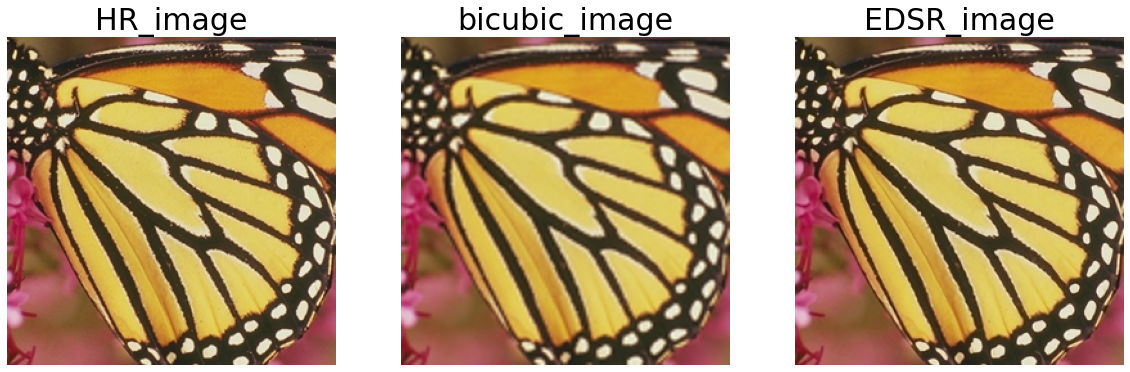

In [11]:
def visualization():
    
    hr_img = pilimg.open('test_sample/test_image/{}/hr_ground/butterfly_GT.bmp'.format(test_set))
    pix_hr = np.array(hr_img)
    
    bicubic_img = pilimg.open('test_sample/test_image/{}/bicubic_rgb/scale{}/bicubic_RGB_{}_3.bmp'.format(test_set, scale, scale))
    pix_bicubic = np.array(bicubic_img)
    
    edsr_img = pilimg.open('output_image/{}/scale{}/predict2.jpg'.format(test_set, scale))
    pix_srcnn = np.array(edsr_img)
    
    fig = plt.figure(figsize = (20,32))
    rows = 1
    cols = 3
    
    ax1 = fig.add_subplot(rows, cols, 1)
    ax1.imshow(hr_img)
    ax1.set_title('HR_image', size = 30)
    ax1.axis('off')
    
    ax2 = fig.add_subplot(rows, cols, 2)
    ax2.imshow(bicubic_img)
    ax2.set_title('bicubic_image', size = 30)
    ax2.axis('off')
    
    ax3 = fig.add_subplot(rows, cols, 3)
    ax3.imshow(edsr_img)
    ax3.set_title('EDSR_image', size = 30)
    ax3.axis('off')
    
    plt.show()
    
    
if __name__ == '__main__':
    
    visualization()

In [ ]:
checkpoint/EDSR_checkpoint_scale2.h5

1
BICUBIC:  36.99283971051909 ssim:  0.787412102837007
EDSR:  38.824770350868384 ssim:  0.8415491872900493
2
BICUBIC:  36.84216811005006 ssim:  0.8553135056308223
EDSR:  43.34268660134886 ssim:  0.882552794013443
3
BICUBIC:  27.452953800744652 ssim:  0.6226942691110665
EDSR:  35.305971460161125 ssim:  0.8068394469309322
4
BICUBIC:  34.77145735971173 ssim:  0.5802093467946988
EDSR:  35.91361796883874 ssim:  0.6234727601659774
5
BICUBIC:  32.22755949277931 ssim:  0.7813733306900829
EDSR:  36.46246280534757 ssim:  0.8430584180312879
Epochs:  1
Bicubic
PSNR:  33.65739569476097 SSIM:  0.7254005110127355
EDSR
PSNR:  37.96990183731293 SSIM:  0.799494521286338